<a href="https://colab.research.google.com/github/VKapitany/Keras_tuner_intro/blob/master/Neural_network_hyperparameter_optimisation_kerastuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Keras-tuner: Keras/Tensorflow Neural Network Hyperparameter Optimisation

adapted from https://keras-team.github.io/keras-tuner/

<center><img src="https://raw.githubusercontent.com/VKapitany/Keras_tuner_intro/master/keras_tuner.png" width=500>

*Keras-tuner is intuitive to use with the inbuilt NNs `HyperResNet` and `Hyperband`.*

*For a custom architecture, this notebook shows how to use keras-tuner.* </center>

### ***Change runtime type to GPU!!***

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
!pip install -U keras-tuner # keras-tuner isn't pre-installed in fresh google colab
                            # virtual machines, but you can install modules using !pip
from kerastuner.tuners import RandomSearch,Hyperband,BayesianOptimization
import random

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=ac1be5d86d68dda9407d37abf0b14b6c41abcef99cb1bec36c381e75636b14a9
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=9efcda31be75eb0a345a24cabab2aade5b4e5b6d914ed61061c5d66024c0659b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Data: we’ll download the MNIST dataset

In [ ]:
from keras.datasets.mnist import load_data
(train_images, train_labels), (test_images, test_labels) = load_data()

train_images = np.reshape(train_images,(-1,784)).astype('float32')
test_images = np.reshape(test_images,(-1,784)).astype('float32')

val_images=train_images[0:10000].astype('float32')
val_labels=train_labels[0:10000].astype('float32')

train_images=train_images[10000::].astype('float32')
train_labels=train_labels[10000::].astype('float32')

test_images=test_images.astype('float32')
test_labels=test_labels.astype('float32')

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


### **Then, we define a model-building function.**
It takes an `hp` argument from which you can sample hyperparameters, such as `hp.Int('units', min_value=32, max_value=512, step=32)` (an integer from a certain range).

In the following code, we will be tuning 3 hyperparameters:
- the `units` parameter of the first Dense layer
- the number of identical hidden layers (`number_of_layers`) between the first hidden layer and the output layer
- the `activation` function of these hidden layers 
- and the `learning_rate` parameters of the optimizer.

For documentation on defining the hyperparameters, see: https://keras-team.github.io/keras-tuner/documentation/hyperparameters/

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(28*28)))
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    for i in range(hp.Int('number_of_layers',min_value = 0,max_value = 4,step=1)):
        model.add(layers.Dense(64, activation=hp.Choice('activation',
                                                        values = ['relu','tanh'])))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

### **Next, instantiate a tuner.**
You should specify:
- model-building function
- the name of the objective to optimize (whether to minimize or maximize is automatically inferred for built-in metrics)
- the total number of trials (`max_trials`) to test
- and the number of models that should be built and fit for each trial (`executions_per_trial`).

Available tuners are `RandomSearch`, `BayesianOptimisation`, `Hyperband` and `Sklearn` (the latter is for sklearn networks).

Note: the purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model. If you want to get results faster, you could set `executions_per_trial=1` (single round of training for each model configuration).

**In this example, Keras tuner will use the `Hyperband` algorithm (https://arxiv.org/pdf/1603.06560.pdf) for the hyperparameter search:**

### Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization:
...

*\"We develop a novel configuration evaluation approach by formulating hyperparameter
optimization as a pure-exploration adaptive resource allocation problem addressing **how to
allocate resources among randomly sampled hyperparameter configurations**.2 Our procedure,
Hyperband, relies on a principled early-stopping strategy to allocate resources, allowing it
to **evaluate orders-of-magnitude more configurations than black-box procedures like Bayesian
optimization methods.** Hyperband is a general-purpose technique that makes minimal
assumptions unlike prior configuration evaluation approaches (Domhan et al., 2015; Swersky
et al., 2014; Gy¨orgy and Kocsis, 2011; Agarwal et al., 2011; Sparks et al., 2015; Jamieson
and Talwalkar, 2015).\"*



...



*\"Our theoretical analysis demonstrates the ability of Hyperband to adapt to unknown
convergence rates and to the behavior of validation losses as a function of the hyperparameters.
In addition, Hyperband is 5× to 30× faster than popular Bayesian optimization algorithms
on a variety of deep-learning and kernel-based learning problems. A theoretical contribution
of this work is the introduction of the pure-exploration, infinite-armed bandit problem in
the non-stochastic setting, for which Hyperband is one solution.\"*

---
*\"In probability theory, the multi-armed bandit problem (sometimes called the K- or N-armed bandit problem) is a problem in which a fixed limited set of resources must be allocated between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice.\"* - https://en.wikipedia.org/wiki/Multi-armed_bandit

In [ ]:
if 'model' in locals(): del model 
keras.backend.clear_session() 

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=15,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='helloworld',
#     overwrite=True)

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld',
    overwrite=True)

# tuner = Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=10,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='helloworld',
#     overwrite=True)

You can print a summary of the search space

In [ ]:
tuner.search_space_summary()

### Finally start the search for the best hyperparameter configuration.
The call to search has the same signature as `model.fit()`. The searches will try out different permutations of your choices, constrained by: the `number of trials`, and the `executions per trial` parameters.

In [ ]:
tuner.search(train_images, train_labels,
             epochs=10,
             batch_size=512,
             validation_data=(val_images, val_labels),
             callbacks=[keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 4.8009 - accuracy: 0.2363 - val_loss: 1.7612 - val_accuracy: 0.3133
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1.5165 - accuracy: 0.3904 - val_loss: 1.3084 - val_accuracy: 0.4636
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1.1980 - accuracy: 0.5050 - val_loss: 1.1001 - val_accuracy: 0.5493
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 1.0803 - accuracy: 0.5462 - val_loss: 1.0785 - val_accuracy: 0.5462
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1.0527 - accuracy: 0.5551 - val_loss: 1.0483 - val_accuracy: 0.5696
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 1.0300 - accuracy: 0.5775 - val_loss: 1.0173 - val_accuracy: 0.6099
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.9132 - accuracy: 0.6572 - val_loss: 0.8448 - val_accuracy: 0.6782
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 4.9880 - accuracy: 0.5922 - val_loss: 0.8519 - val_accuracy: 0.7863
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.6536 - accuracy: 0.8262 - val_loss: 0.5507 - val_accuracy: 0.8523
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.4468 - accuracy: 0.8752 - val_loss: 0.4415 - val_accuracy: 0.8784
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.3455 - accuracy: 0.9024 - val_loss: 0.3653 - val_accuracy: 0.8989
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2825 - accuracy: 0.9178 - val_loss: 0.3245 - val_accuracy: 0.9124
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2429 - accuracy: 0.9292 - val_loss: 0.3139 - val_accuracy: 0.9162
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2128 - accuracy: 0.9367 - val_loss: 0.2890 - val_accuracy: 0.9212
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 23.7695 - accuracy: 0.6384 - val_loss: 6.6926 - val_accuracy: 0.8328
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 5.2343 - accuracy: 0.8587 - val_loss: 4.3308 - val_accuracy: 0.8788
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 3.4950 - accuracy: 0.8930 - val_loss: 3.3584 - val_accuracy: 0.8968
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 2.5576 - accuracy: 0.9127 - val_loss: 2.8672 - val_accuracy: 0.9064
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1.9926 - accuracy: 0.9251 - val_loss: 2.4852 - val_accuracy: 0.9148
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 1.5802 - accuracy: 0.9355 - val_loss: 2.2317 - val_accuracy: 0.9210
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1.2589 - accuracy: 0.9450 - val_loss: 2.0816 - val_accuracy: 0.9243
Epoch 8/10
98/98 [=

Epoch 1/10
98/98 [==============================] - 1s 6ms/step - loss: 4.8270 - accuracy: 0.4886 - val_loss: 1.3548 - val_accuracy: 0.7196
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 1.0167 - accuracy: 0.7717 - val_loss: 0.8320 - val_accuracy: 0.8182
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.6421 - accuracy: 0.8452 - val_loss: 0.6392 - val_accuracy: 0.8563
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.4673 - accuracy: 0.8826 - val_loss: 0.5406 - val_accuracy: 0.8765
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.3644 - accuracy: 0.9053 - val_loss: 0.4744 - val_accuracy: 0.8910
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2959 - accuracy: 0.9218 - val_loss: 0.4340 - val_accuracy: 0.8991
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2458 - accuracy: 0.9341 - val_loss: 0.3975 - val_accuracy: 0.9077
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 2.0729 - accuracy: 0.2809 - val_loss: 1.7214 - val_accuracy: 0.4593
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 1.4785 - accuracy: 0.5398 - val_loss: 1.2585 - val_accuracy: 0.6163
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1.1129 - accuracy: 0.6670 - val_loss: 0.9839 - val_accuracy: 0.7096
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.8912 - accuracy: 0.7346 - val_loss: 0.8096 - val_accuracy: 0.7613
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.7408 - accuracy: 0.7796 - val_loss: 0.6867 - val_accuracy: 0.7971
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.8109 - val_loss: 0.6022 - val_accuracy: 0.8260
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.5627 - accuracy: 0.8327 - val_loss: 0.5393 - val_accuracy: 0.8445
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 0s 5ms/step - loss: 57.4071 - accuracy: 0.1973 - val_loss: 20.2309 - val_accuracy: 0.3148
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 12.0346 - accuracy: 0.3340 - val_loss: 6.6622 - val_accuracy: 0.3638
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 4.8219 - accuracy: 0.3614 - val_loss: 3.6668 - val_accuracy: 0.3685
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 3.1480 - accuracy: 0.3591 - val_loss: 2.7979 - val_accuracy: 0.3695
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 2.5722 - accuracy: 0.3611 - val_loss: 2.4251 - val_accuracy: 0.3722
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 2.3035 - accuracy: 0.3673 - val_loss: 2.2268 - val_accuracy: 0.3812
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 2.1449 - accuracy: 0.3736 - val_loss: 2.1026 - val_accuracy: 0.3883
Epoch 8/10
98/98 

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 2.0664 - accuracy: 0.2225 - val_loss: 2.1402 - val_accuracy: 0.1883
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 2.3246 - accuracy: 0.1054 - val_loss: 2.3104 - val_accuracy: 0.0991
Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 2.2354 - accuracy: 0.1598 - val_loss: 2.1100 - val_accuracy: 0.1821
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 2.0548 - accuracy: 0.1942 - val_loss: 2.1497 - val_accuracy: 0.1394
Epoch 1/10
98/98 [==============================] - 1s 6ms/step - loss: 2.0642 - accuracy: 0.2284 - val_loss: 2.0577 - val_accuracy: 0.1920
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 2.0377 - accuracy: 0.2284 - val_loss: 2.1048 - val_accuracy: 0.1828


Epoch 1/10
98/98 [==============================] - 0s 5ms/step - loss: 36.9985 - accuracy: 0.7978 - val_loss: 0.6436 - val_accuracy: 0.8644
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.5043 - accuracy: 0.8863 - val_loss: 0.4889 - val_accuracy: 0.9059
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3598 - accuracy: 0.9148 - val_loss: 0.4098 - val_accuracy: 0.9172
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2909 - accuracy: 0.9259 - val_loss: 0.3662 - val_accuracy: 0.9274
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.2515 - accuracy: 0.9336 - val_loss: 0.3473 - val_accuracy: 0.9315
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.2242 - accuracy: 0.9404 - val_loss: 0.3196 - val_accuracy: 0.9322
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.1905 - accuracy: 0.9456 - val_loss: 0.3161 - val_accuracy: 0.9399
Epoch 8/10
98/98 [=

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 21.6334 - accuracy: 0.6525 - val_loss: 6.0980 - val_accuracy: 0.8428
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 4.8905 - accuracy: 0.8645 - val_loss: 3.9810 - val_accuracy: 0.8890
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 3.1950 - accuracy: 0.8993 - val_loss: 3.0517 - val_accuracy: 0.9059
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 2.3421 - accuracy: 0.9161 - val_loss: 2.5885 - val_accuracy: 0.9140
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 1.7801 - accuracy: 0.9310 - val_loss: 2.2724 - val_accuracy: 0.9217
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 1.4020 - accuracy: 0.9398 - val_loss: 2.0406 - val_accuracy: 0.9275
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1.1240 - accuracy: 0.9473 - val_loss: 1.9277 - val_accuracy: 0.9305
Epoch 8/10
98/98 [=

Epoch 1/10
98/98 [==============================] - 1s 6ms/step - loss: 19.3391 - accuracy: 0.1833 - val_loss: 5.0580 - val_accuracy: 0.3267
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 3.4431 - accuracy: 0.3832 - val_loss: 2.3383 - val_accuracy: 0.4632
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 1.9898 - accuracy: 0.4992 - val_loss: 1.6596 - val_accuracy: 0.5560
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 1.4978 - accuracy: 0.5848 - val_loss: 1.3275 - val_accuracy: 0.6247
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1.2216 - accuracy: 0.6478 - val_loss: 1.1197 - val_accuracy: 0.6696
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 1.0402 - accuracy: 0.6921 - val_loss: 0.9800 - val_accuracy: 0.7087
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.9129 - accuracy: 0.7283 - val_loss: 0.8736 - val_accuracy: 0.7424
Epoch 8/10
98/98 [=

Epoch 1/10
98/98 [==============================] - 0s 5ms/step - loss: 5.4925 - accuracy: 0.2090 - val_loss: 2.0030 - val_accuracy: 0.2271
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1.8744 - accuracy: 0.2820 - val_loss: 1.7628 - val_accuracy: 0.3291
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1.6769 - accuracy: 0.3488 - val_loss: 1.7081 - val_accuracy: 0.3430
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 1.6405 - accuracy: 0.3559 - val_loss: 1.5993 - val_accuracy: 0.3835
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1.5680 - accuracy: 0.3898 - val_loss: 1.5255 - val_accuracy: 0.4080
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 1.4805 - accuracy: 0.4178 - val_loss: 1.3941 - val_accuracy: 0.4560
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1.3829 - accuracy: 0.4487 - val_loss: 1.3111 - val_accuracy: 0.4624
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 1s 6ms/step - loss: 1.7098 - accuracy: 0.4945 - val_loss: 1.1852 - val_accuracy: 0.7199
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.9398 - accuracy: 0.7786 - val_loss: 0.7354 - val_accuracy: 0.8292
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.6296 - accuracy: 0.8517 - val_loss: 0.5372 - val_accuracy: 0.8716
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.4850 - accuracy: 0.8793 - val_loss: 0.4340 - val_accuracy: 0.8889
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.4002 - accuracy: 0.8961 - val_loss: 0.3761 - val_accuracy: 0.8989
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.3480 - accuracy: 0.9079 - val_loss: 0.3359 - val_accuracy: 0.9077
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.3131 - accuracy: 0.9145 - val_loss: 0.3090 - val_accuracy: 0.9128
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 33.2650 - accuracy: 0.7565 - val_loss: 1.1025 - val_accuracy: 0.8032
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.8433 - accuracy: 0.8267 - val_loss: 0.7873 - val_accuracy: 0.8502
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.5894 - accuracy: 0.8707 - val_loss: 0.6549 - val_accuracy: 0.8852
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.4581 - accuracy: 0.8942 - val_loss: 0.5945 - val_accuracy: 0.8958
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3725 - accuracy: 0.9093 - val_loss: 0.5456 - val_accuracy: 0.9109
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3303 - accuracy: 0.9181 - val_loss: 0.5180 - val_accuracy: 0.9062
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.2863 - accuracy: 0.9278 - val_loss: 0.4858 - val_accuracy: 0.9132
Epoch 8/10
98/98 [=

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 1.8865 - accuracy: 0.3822 - val_loss: 1.3051 - val_accuracy: 0.6494
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1.0757 - accuracy: 0.7249 - val_loss: 0.8612 - val_accuracy: 0.7905
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.7572 - accuracy: 0.8158 - val_loss: 0.6393 - val_accuracy: 0.8443
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.8550 - val_loss: 0.5187 - val_accuracy: 0.8704
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.4949 - accuracy: 0.8752 - val_loss: 0.4532 - val_accuracy: 0.8827
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.4311 - accuracy: 0.8882 - val_loss: 0.4020 - val_accuracy: 0.8915
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.3862 - accuracy: 0.8973 - val_loss: 0.3674 - val_accuracy: 0.9040
Epoch 8/10
98/98 [==

Epoch 1/10
98/98 [==============================] - 1s 5ms/step - loss: 11.3497 - accuracy: 0.6001 - val_loss: 3.0878 - val_accuracy: 0.7836
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 2.3365 - accuracy: 0.8154 - val_loss: 1.9271 - val_accuracy: 0.8326
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1.4842 - accuracy: 0.8576 - val_loss: 1.4579 - val_accuracy: 0.8588
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 1.0710 - accuracy: 0.8807 - val_loss: 1.2079 - val_accuracy: 0.8733
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.8209 - accuracy: 0.8979 - val_loss: 1.0406 - val_accuracy: 0.8853
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.6519 - accuracy: 0.9113 - val_loss: 0.9459 - val_accuracy: 0.8931
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.5301 - accuracy: 0.9231 - val_loss: 0.8721 - val_accuracy: 0.9002
Epoch 8/10
98/98 [=

INFO:tensorflow:Oracle triggered exit


Here's what happens in search: models are built iteratively by calling the model-building function, which populates the hyperparameter space (search space) tracked by the hp object. The tuner progressively explores the space, recording metrics for each configuration.

When search is over, you can retrieve the best model(s):

In [ ]:
models = tuner.get_best_models(1)[0] #this is the best model. Set get_best_models(2)
                                     # to get the 2 best models, etc.

Or print a summary of the results. The models are listed **best to worst**, so the saved model has the parameters shown at the top of the list. 


In [ ]:
tuner.results_summary()

In [ ]:
from tensorflow.keras.models import load_model 
test_loss, test_acc = models.evaluate(test_images,test_labels)
print('Accuracy',test_acc)
predictions = models.predict(test_images)
print(models.summary())

313/313 [==============================] - 1s 2ms/step - loss: 0.3133 - accuracy: 0.9427
Accuracy 0.9427000284194946
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None


### Predictions with the (not fully trained) tuned model

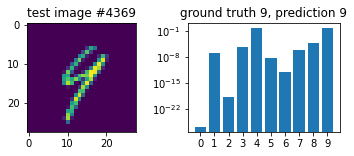

In [ ]:
co = random.randint(0,len(test_images))
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.title('test image #{}'.format(co))
plt.imshow(test_images[co].reshape([28,28]))
plt.subplot(122)
plt.bar(range(10),predictions[co])
plt.title('ground truth {}, prediction {}'.format(int(test_labels[co]),
                                                  np.argmax(predictions[co])),)
plt.yscale('log')
plt.xticks(range(10))
plt.show()

##Complete training of optimal model

Once you have tuned your hyperparameters parameters, don't forget to fully train your model (i.e. further train for a decent number of epochs)! 

The model has been pre-trained a bit during parameter search, but it's best to keep training it further until you achieve best generalisation (best performance on validation set)

In [ ]:
models.fit(train_images, train_labels,
             epochs=50,
             batch_size=512,
             validation_data=(val_images, val_labels),
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])
models.save('final_model.h5')
test_loss, test_acc = models.evaluate(test_images,test_labels)
print('Accuracy',test_acc)



Epoch 1/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1469 - accuracy: 0.9578 - val_loss: 0.2813 - val_accuracy: 0.9431
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1359 - accuracy: 0.9604 - val_loss: 0.3033 - val_accuracy: 0.9436
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1427 - accuracy: 0.9589 - val_loss: 0.2974 - val_accuracy: 0.9457
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.9616 - val_loss: 0.2931 - val_accuracy: 0.9455
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1338 - accuracy: 0.9614 - val_loss: 0.3131 - val_accuracy: 0.9430
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.3311 - accuracy: 0.9476
Accuracy 0.9476000070571899


Predictions with the final model

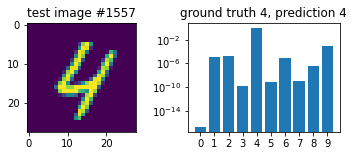

In [ ]:
predictions = models.predict(test_images)

co = random.randint(0,len(test_images))
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.title('test image #{}'.format(co))
plt.imshow(test_images[co].reshape([28,28]))
plt.subplot(122)
plt.bar(range(10),predictions[co])
plt.title('ground truth {}, prediction {}'.format(int(test_labels[co]),
                                                  np.argmax(predictions[co])),)
plt.yscale('log')
plt.xticks(range(10))
plt.show()

for more documentation, see https://github.com/keras-team/keras-tuner

Alternative APIs to try:
 - GPFlowOpt https://gpflowopt.readthedocs.io/en/latest/intro.html
 